# Subreddit Stats

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as md
import numpy as np
import praw
from psaw import PushshiftAPI
import datetime
import yaml
import time
from sortedcontainers import SortedDict
from collections import OrderedDict

## Parameters

In [2]:
start_epoch = int(datetime.datetime(2018, 1, 1).timestamp())
start_subs = 680       # number of subs at start_epoch (needed if before 2018/3/15, see redditmetrics.com)
end_epoch = int(datetime.datetime(2019, 1, 1).timestamp())
max_posts = 10000      # max number of posts to crawl, None for unlimited
sub = 'dreamcatcher'   # subreddit to crawl

## Get Data

In [3]:
class Comment:
    def __init__(self):
        self.body = ''
        self.author = ''
        self.score = 0
        self.ts = 0
        self.url = ''

class Post:
    def __init__(self):
        self.title = ''
        self.author = ''
        self.ts = 0
        self.score = 0
        self.comments = []
        self.url = ''

In [4]:
stream = open('client_info.txt', 'r')
doc = yaml.load(stream)

r = praw.Reddit(client_id=doc['client_id'],
                client_secret=doc['client_secret'],
                user_agent='test'
                )
api_ps_praw = PushshiftAPI(r)
api_ps = PushshiftAPI()
post_ids = api_ps_praw.search_submissions(after=start_epoch,
                                  before=end_epoch,
                                  subreddit=sub,
                                  filter=['url', 'author', 'title', 'subreddit'],
                                  limit=max_posts)
subs = api_ps.search_submissions(after=start_epoch,
                                  before=end_epoch,
                                  subreddit=sub,
                                  filter=['subreddit', 'id', 'subreddit_subscribers'],
                                  limit=max_posts)
id2subs = {}

for s in subs:
    if hasattr(s, 'subreddit_subscribers'):
        num_subs = s.subreddit_subscribers
    else:
        num_subs = -1    
    id2subs[s.id] = num_subs
            
subcount = SortedDict()
posts = []
prev_info_len = 1

for i, post_id in enumerate(post_ids):
    submission = praw.models.Submission(r, id=post_id)
    ts = int(submission.created_utc)
    subcount[ts] = id2subs[post_id.id]
    submission.comments.replace_more()
    comment_ids = submission.comments.list()
    c = []
    
    for comment_id in comment_ids:
        comment = praw.models.Comment(r, id=comment_id)
        temp = Comment()
        temp.body = comment.body
        temp.author = comment.author
        temp.ts = comment.created_utc
        temp.score = comment.score
        temp.url = comment.permalink
        c.append(temp)
    
    ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    temp = Post()
    temp.title = submission.title
    temp.author = submission.author
    temp.ts = submission.created_utc
    temp.score = submission.score
    temp.comments = c
    temp.url = submission.permalink
    posts.append(temp)
    
    title = (temp.title[:47] + '...') if len(temp.title) > 47 else temp.title
    info = '%05d: %s --- %s' % (i, ts_str, title)
    clear = ' ' * prev_info_len
    print('%s' % clear, end='\r', flush=True)
    prev_info_len = len(info)
    print('%s' % info, end='\r', flush=True)
    
num_posts = i+1
    
print('\ndone')

03278: 2018-01-01 15:20:23 --- Dreamcatcher end of year awards                   ..
done


## Visualize Data

### Subscriber Growth

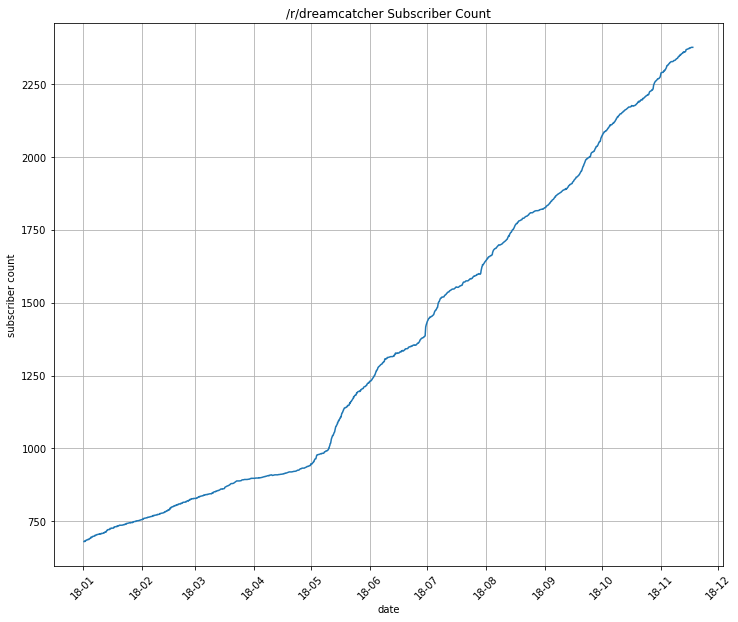

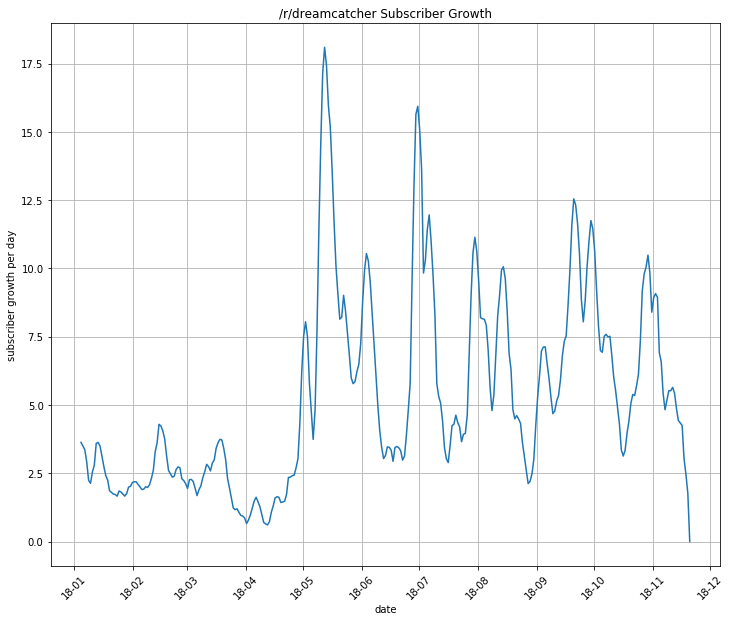

In [53]:
# fix (interpolate) bad sub count data
timestamps = np.zeros(len(subcount))
subs = np.zeros(len(subcount))
no_sub_data_end = -1
for i, ts in enumerate(subcount):
    timestamps[i] = ts
    subs[i] = subcount[ts]
    if subs[i] == -1:
        no_sub_data_end = i
        
if start_subs is not None:
    if no_sub_data_end < len(subs)+1:
        subs[:no_sub_data_end+1] = np.floor(np.linspace(start_subs, subs[no_sub_data_end+1], no_sub_data_end+1))

for i, s in enumerate(subs):
    subcount[timestamps[i]] = s

# sub count
        
dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]
    
plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, subs)
plt.xlabel('date')
plt.ylabel('subscriber count')
plt.title('/r/%s Subscriber Count' % (sub))
plt.grid(b=True, which='both', axis='both')

# sub growth

secs_in_day = 86400

ts_begin = start_epoch
ts_end = 7 * secs_in_day + ts_begin # days after ts_begin

sub_growth_ts = []
sub_growth = []
while ts_end < end_epoch:
    it = subcount.irange(ts_begin, ts_end)
    temp_ts = []
    temp_subcount = []
    for ts in it:
        temp_ts.append(ts)
        temp_subcount.append(subcount[ts])
    if len(temp_ts) != 0:
        p_fit = np.polyfit(temp_ts, temp_subcount, 1)
        sub_growth_ts.append((ts_begin + ts_end)/2)
        sub_growth.append(p_fit[0])
    ts_begin += secs_in_day
    ts_end += secs_in_day

dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in sub_growth_ts])
sub_growth = np.array(sub_growth) * secs_in_day

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, sub_growth)
plt.xlabel('date')
plt.ylabel('subscriber growth per day')
plt.title('/r/%s Subscriber Growth' % (sub))
plt.grid(b=True, which='both', axis='both')

plt.show()

## Leaderboards

### Top Posts

In [6]:
adj_scores = np.zeros((len(posts)), dtype=float)
for i, post in enumerate(posts):
    ts = int(post.ts)
    adj_scores[i] = (float(post.score) / subcount[ts])


top_idx = (-adj_scores).argsort()[:10]

for i, idx in enumerate(top_idx):
    post = posts[idx]
    ts = int(post.ts)
    ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    print('top post #%d' % (i+1))
    print('title:          %s' % (post.title))
    print('author:         %s' % (post.author))
    print('time:           %s' % (ts_str))
    print('score:          %d' % (post.score))
    print('adjusted score: %f' % (float(post.score) / subcount[int(post.ts)]))
    print('comments:       %d' % (len(post.comments)))
    print('permalink:      https://www.reddit.com%s' % (post.url))
    print()

top post #1
title:          Dreamcatcher (드림캐쳐) - 'YOU AND I' MV
author:         SpideyCyclist
time:           2018-05-10 09:01:59
score:          174
adjusted score: 0.174174
comments:       15
permalink:      https://www.reddit.com/r/dreamcatcher/comments/8idh2r/dreamcatcher_드림캐쳐_you_and_i_mv/

top post #2
title:          New Fans Guide To Dreamcatcher
author:         SpideyCyclist
time:           2018-05-10 13:41:43
score:          122
adjusted score: 0.121878
comments:       29
permalink:      https://www.reddit.com/r/dreamcatcher/comments/8ieyin/new_fans_guide_to_dreamcatcher/

top post #3
title:          Dami, please..
author:         myblindy
time:           2018-05-11 15:08:56
score:          115
adjusted score: 0.112195
comments:       7
permalink:      https://www.reddit.com/r/dreamcatcher/comments/8ioh7t/dami_please/

top post #4
title:          Dreamcatcher (드림캐쳐) - 'What' MV
author:         SpideyCyclist
time:           2018-09-20 09:00:45
score:          194
adjusted scor

### Top Comments

In [7]:
all_comments = []
comment_ts2post_ts = {}
for i, post in enumerate(posts):
    ts = int(post.ts)
    for comment in post.comments:
        all_comments.append(comment)
        if comment.ts not in comment_ts2post_ts:
            comment_ts2post_ts[comment.ts] = ts

adj_scores = np.zeros((len(all_comments)), dtype=float)
for i in range(len(all_comments)):
    ts = int(all_comments[i].ts)
    adj_scores[i] = float(all_comments[i].score) / subcount[comment_ts2post_ts[ts]]
    
top_idx = (-adj_scores).argsort()[:10]

for i, idx in enumerate(top_idx):
    comment = all_comments[idx]
    body = comment.body.replace('\n', ' ')
    body = (body[:97] + '...') if len(body) > 97 else body
    ts = int(comment.ts)
    ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    print('top comment #%d' % (i+1))
    print('comment:        %s' % (body))
    print('author:         %s' % (comment.author))
    print('time:           %s' % (ts_str))
    print('score:          %d' % (comment.score))
    print('adjusted score: %f' % (adj_scores[idx]))
    print('permalink:      https://www.reddit.com%s' % (comment.url))
    print()

top comment #1
comment:        Hi everyone,  International fans \- this day is dedicated to you. After working tirelessly with H...
author:         DCUnion-Astraea
time:           2018-06-01 11:29:20
score:          30
adjusted score: 0.024370
permalink:      https://www.reddit.com/r/dreamcatcher/comments/8nr4bi/eng_subs_available_on_dreamcatcher_videos/dzxndb0/

top comment #2
comment:        Oh. My. God.   I made that jumper for her! Gave it to her in London!!! Freaking out a little bit....
author:         davefeeder
time:           2018-02-20 06:44:30
score:          19
adjusted score: 0.023514
permalink:      https://www.reddit.com/r/dreamcatcher/comments/7yttg6/yoohyeon_shark_doo_doo_doo_doo_doo_doo/duj5inx/

top comment #3
comment:        Everybody's rushing to check if she's okay while Gahyeon's busy laughing her ass off. This maknae...
author:         CDN_Datawraith
time:           2018-05-20 18:55:44
score:          22
adjusted score: 0.019164
permalink:      https://www.reddi

### Top Posters

In [8]:
users = OrderedDict()
for i, post in enumerate(posts):
    ts = int(post.ts)
    if post.author == None:
        continue
    if post.author not in users:
        users[post.author] = {}
        users[post.author]['score'] = 0
        users[post.author]['adj_score'] = 0
        users[post.author]['posts'] = 0
        users[post.author]['comment_score'] = 0
        users[post.author]['adj_comment_score'] = 0
        users[post.author]['comments'] = 0
    users[post.author]['score'] += post.score
    users[post.author]['adj_score'] += (float(post.score) / subcount[ts])
    users[post.author]['posts'] += 1
    for comment in post.comments:
        if comment.author not in users:
            users[comment.author] = {}
            users[comment.author]['score'] = 0
            users[comment.author]['adj_score'] = 0
            users[comment.author]['posts'] = 0
            users[comment.author]['comment_score'] = 0
            users[comment.author]['adj_comment_score'] = 0
            users[comment.author]['comments'] = 0
        users[comment.author]['comment_score'] += comment.score
        users[comment.author]['adj_comment_score'] += (float(comment.score) / subcount[ts])
        users[comment.author]['comments'] += 1

In [9]:
sorted_posters = OrderedDict(sorted(users.items(), key=lambda x: x[1]['adj_score'], reverse=True))

for i, key in enumerate(sorted_posters):
    if i >= 10:
        break
    print('top poster #%d' % (i+1))
    print('user:                  %s' % (key))
    print('total number of posts: %d' % (sorted_posters[key]['posts']))
    print('total score:           %d' % (sorted_posters[key]['score']))
    print('total adjusted score:  %f' % (sorted_posters[key]['adj_score']))
    print()

top poster #1
user:                  SpideyCyclist
total number of posts: 2344
total score:           62291
total adjusted score:  30.711469

top poster #2
user:                  myblindy
total number of posts: 71
total score:           3523
total adjusted score:  3.026467

top poster #3
user:                  CDN_Datawraith
total number of posts: 84
total score:           2395
total adjusted score:  1.436343

top poster #4
user:                  kyunikeon
total number of posts: 60
total score:           2388
total adjusted score:  1.170701

top poster #5
user:                  GenghisKhaii
total number of posts: 40
total score:           1184
total adjusted score:  0.732363

top poster #6
user:                  AmaryllisDC
total number of posts: 11
total score:           688
total adjusted score:  0.535095

top poster #7
user:                  davefeeder
total number of posts: 26
total score:           481
total adjusted score:  0.522335

top poster #8
user:                  Naienitsu

## Top Commenters

In [10]:
sorted_commenters = OrderedDict(sorted(users.items(), key=lambda x: x[1]['adj_comment_score'], reverse=True))

for i, key in enumerate(sorted_commenters):
    if i >= 10:
        break
    print('top commenter #%d' % (i+1))
    print('user:                          %s' % (key))
    print('total number of comments:      %d' % (sorted_commenters[key]['comments']))
    print('total comment score:           %d' % (sorted_commenters[key]['comment_score']))
    print('total adjusted comment score:  %f' % (sorted_commenters[key]['adj_comment_score']))
    print()

top commenter #1
user:                          SpideyCyclist
total number of comments:      2824
total comment score:           8149
total adjusted comment score:  5.748267

top commenter #2
user:                          internet0jesus
total number of comments:      950
total comment score:           4356
total adjusted comment score:  2.434907

top commenter #3
user:                          dreamcatcherERA
total number of comments:      342
total comment score:           1385
total adjusted comment score:  0.918437

top commenter #4
user:                          Darrens_Coconut
total number of comments:      244
total comment score:           1239
total adjusted comment score:  0.681192

top commenter #5
user:                          ipwnmice
total number of comments:      207
total comment score:           947
total adjusted comment score:  0.575257

top commenter #6
user:                          davefeeder
total number of comments:      163
total comment score:           525
t

#### Misc

In [11]:
temp = OrderedDict()
for user in users:
    if user not in temp:
        temp[user] = {}
        
    if users[user]['posts'] == 0:
        temp[user]['avg_adj_score'] = 0;
    else:
        temp[user]['avg_adj_score'] = users[user]['adj_score'] / users[user]['posts']
        
    if users[user]['comments'] == 0:
        temp[user]['avg_adj_comment_score'] = 0;
    else:
        temp[user]['avg_adj_comment_score'] = users[user]['adj_comment_score'] / users[user]['comments']


In [12]:
sorted_avg_posters = OrderedDict(sorted(temp.items(), key=lambda x: x[1]['avg_adj_score'], reverse=True))

for i, key in enumerate(sorted_avg_posters):
    if i >= 10:
        break
    print('top avg poster #%d' % (i+1))
    print('user:                  %s' % (key))
    print('avg adjusted score:    %f' % (sorted_avg_posters[key]['avg_adj_score']))
    print('total number of posts: %d' % (users[key]['posts']))
    print('total score:           %d' % (users[key]['score']))
    print('total adjusted score:  %f' % (users[key]['adj_score']))
    print()

top avg poster #1
user:                  ItFactorScott
avg adjusted score:    0.080957
total number of posts: 1
total score:           88
total adjusted score:  0.080957

top avg poster #2
user:                  JuanseCap
avg adjusted score:    0.054764
total number of posts: 1
total score:           73
total adjusted score:  0.054764

top avg poster #3
user:                  AmaryllisDC
avg adjusted score:    0.048645
total number of posts: 11
total score:           688
total adjusted score:  0.535095

top avg poster #4
user:                  Mark_Kostecki
avg adjusted score:    0.045537
total number of posts: 2
total score:           117
total adjusted score:  0.091073

top avg poster #5
user:                  secular_logic
avg adjusted score:    0.044647
total number of posts: 1
total score:           93
total adjusted score:  0.044647

top avg poster #6
user:                  myblindy
avg adjusted score:    0.042626
total number of posts: 71
total score:           3523
total adjust

In [13]:
sorted_avg_posters = OrderedDict(sorted(temp.items(), key=lambda x: x[1]['avg_adj_comment_score'], reverse=True))

for i, key in enumerate(sorted_avg_posters):
    if i >= 10:
        break
    print('top avg commenter #%d' % (i+1))
    print('user:                         %s' % (key))
    print('avg adjusted comment score:   %f' % (sorted_avg_posters[key]['avg_adj_comment_score']))
    print('total number of comments:     %d' % (users[key]['comments']))
    print('total comment score:          %d' % (users[key]['comment_score']))
    print('total adjusted comment score: %f' % (users[key]['adj_comment_score']))
    print()

top avg commenter #1
user:                         YoohyeonJ
avg adjusted comment score:   0.008252
total number of comments:     1
total comment score:          11
total adjusted comment score: 0.008252

top avg commenter #2
user:                         winterman22
avg adjusted comment score:   0.007632
total number of comments:     2
total comment score:          12
total adjusted comment score: 0.015265

top avg commenter #3
user:                         swelleh
avg adjusted comment score:   0.007492
total number of comments:     2
total comment score:          21
total adjusted comment score: 0.014984

top avg commenter #4
user:                         mxag09
avg adjusted comment score:   0.007290
total number of comments:     1
total comment score:          12
total adjusted comment score: 0.007290

top avg commenter #5
user:                         Erato89
avg adjusted comment score:   0.005902
total number of comments:     3
total comment score:          14
total adjusted comme